# What price should I sell my website for?

Let's say I have a website on data science that I started in 2018 and want to sell it now. I go to Flippa.com and check out similar closed autions to see how much the websites sold for. I believe that 5 factors determine whether the website sells in its first auction or not:

- site age
- authority score
- monthly traffic
- net profit

I want to determine the listing price for my website in the Flippa auction so that it sells for as much as possible without diminshing the likeihood of selling on the first auction listing.    

Inspiration: http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/#fully-worked-example-what-price-should-i-sell-my-used-phone-for

In [30]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Here are 8 fake closed Flippa listings that we will use to build our model of whether the website was sold in its first auction. 

In [2]:
df = pd.DataFrame({'site_age': [0.5, 1, 2.2, 2, 2, 5, 4, 10], 
                   'authority_score': [0, 4, 15, 50, 30, 10, 65, 70], 
                   'monthly_traffic':[2001, 14000, 3900, 4721, 3802, 23843, 4905, 2300],
                   'net_profit':[1799, 2000, 12, 240, 400, 590, 700, 9000],
                  "listing_price":[2000, 301, 1030, 5000, 360, 620, 900, 12000],
                  "sold":[0, 0, 0, 0, 1, 1, 1, 1]})
df

,site_age,authority_score,monthly_traffic,net_profit,listing_price,sold
0,0.5,0,2001,1799,2000,0
1,1.0,4,14000,2000,301,0
2,2.2,15,3900,12,1030,0
3,2.0,50,4721,240,5000,0
4,2.0,30,3802,400,360,1
5,5.0,10,23843,590,620,1
6,4.0,65,4905,700,900,1
7,10.0,70,2300,9000,12000,1


In [3]:
# Scale data to improve convergence
df['monthly_traffic'] = df['monthly_traffic']/10000
df['net_profit'] = df['net_profit']/1000
df['listing_price'] = df['listing_price']/1000
df['authority_score'] = df['authority_score']/10
df

,site_age,authority_score,monthly_traffic,net_profit,listing_price,sold
0,0.5,0.0,0.2001,1.799,2.000,0
1,1.0,0.4,1.4000,2.000,0.301,0
2,2.2,1.5,0.3900,0.012,1.030,0
3,2.0,5.0,0.4721,0.240,5.000,0
4,2.0,3.0,0.3802,0.400,0.360,1
5,5.0,1.0,2.3843,0.590,0.620,1
6,4.0,6.5,0.4905,0.700,0.900,1
7,10.0,7.0,0.2300,9.000,12.000,1


## Explore the Data

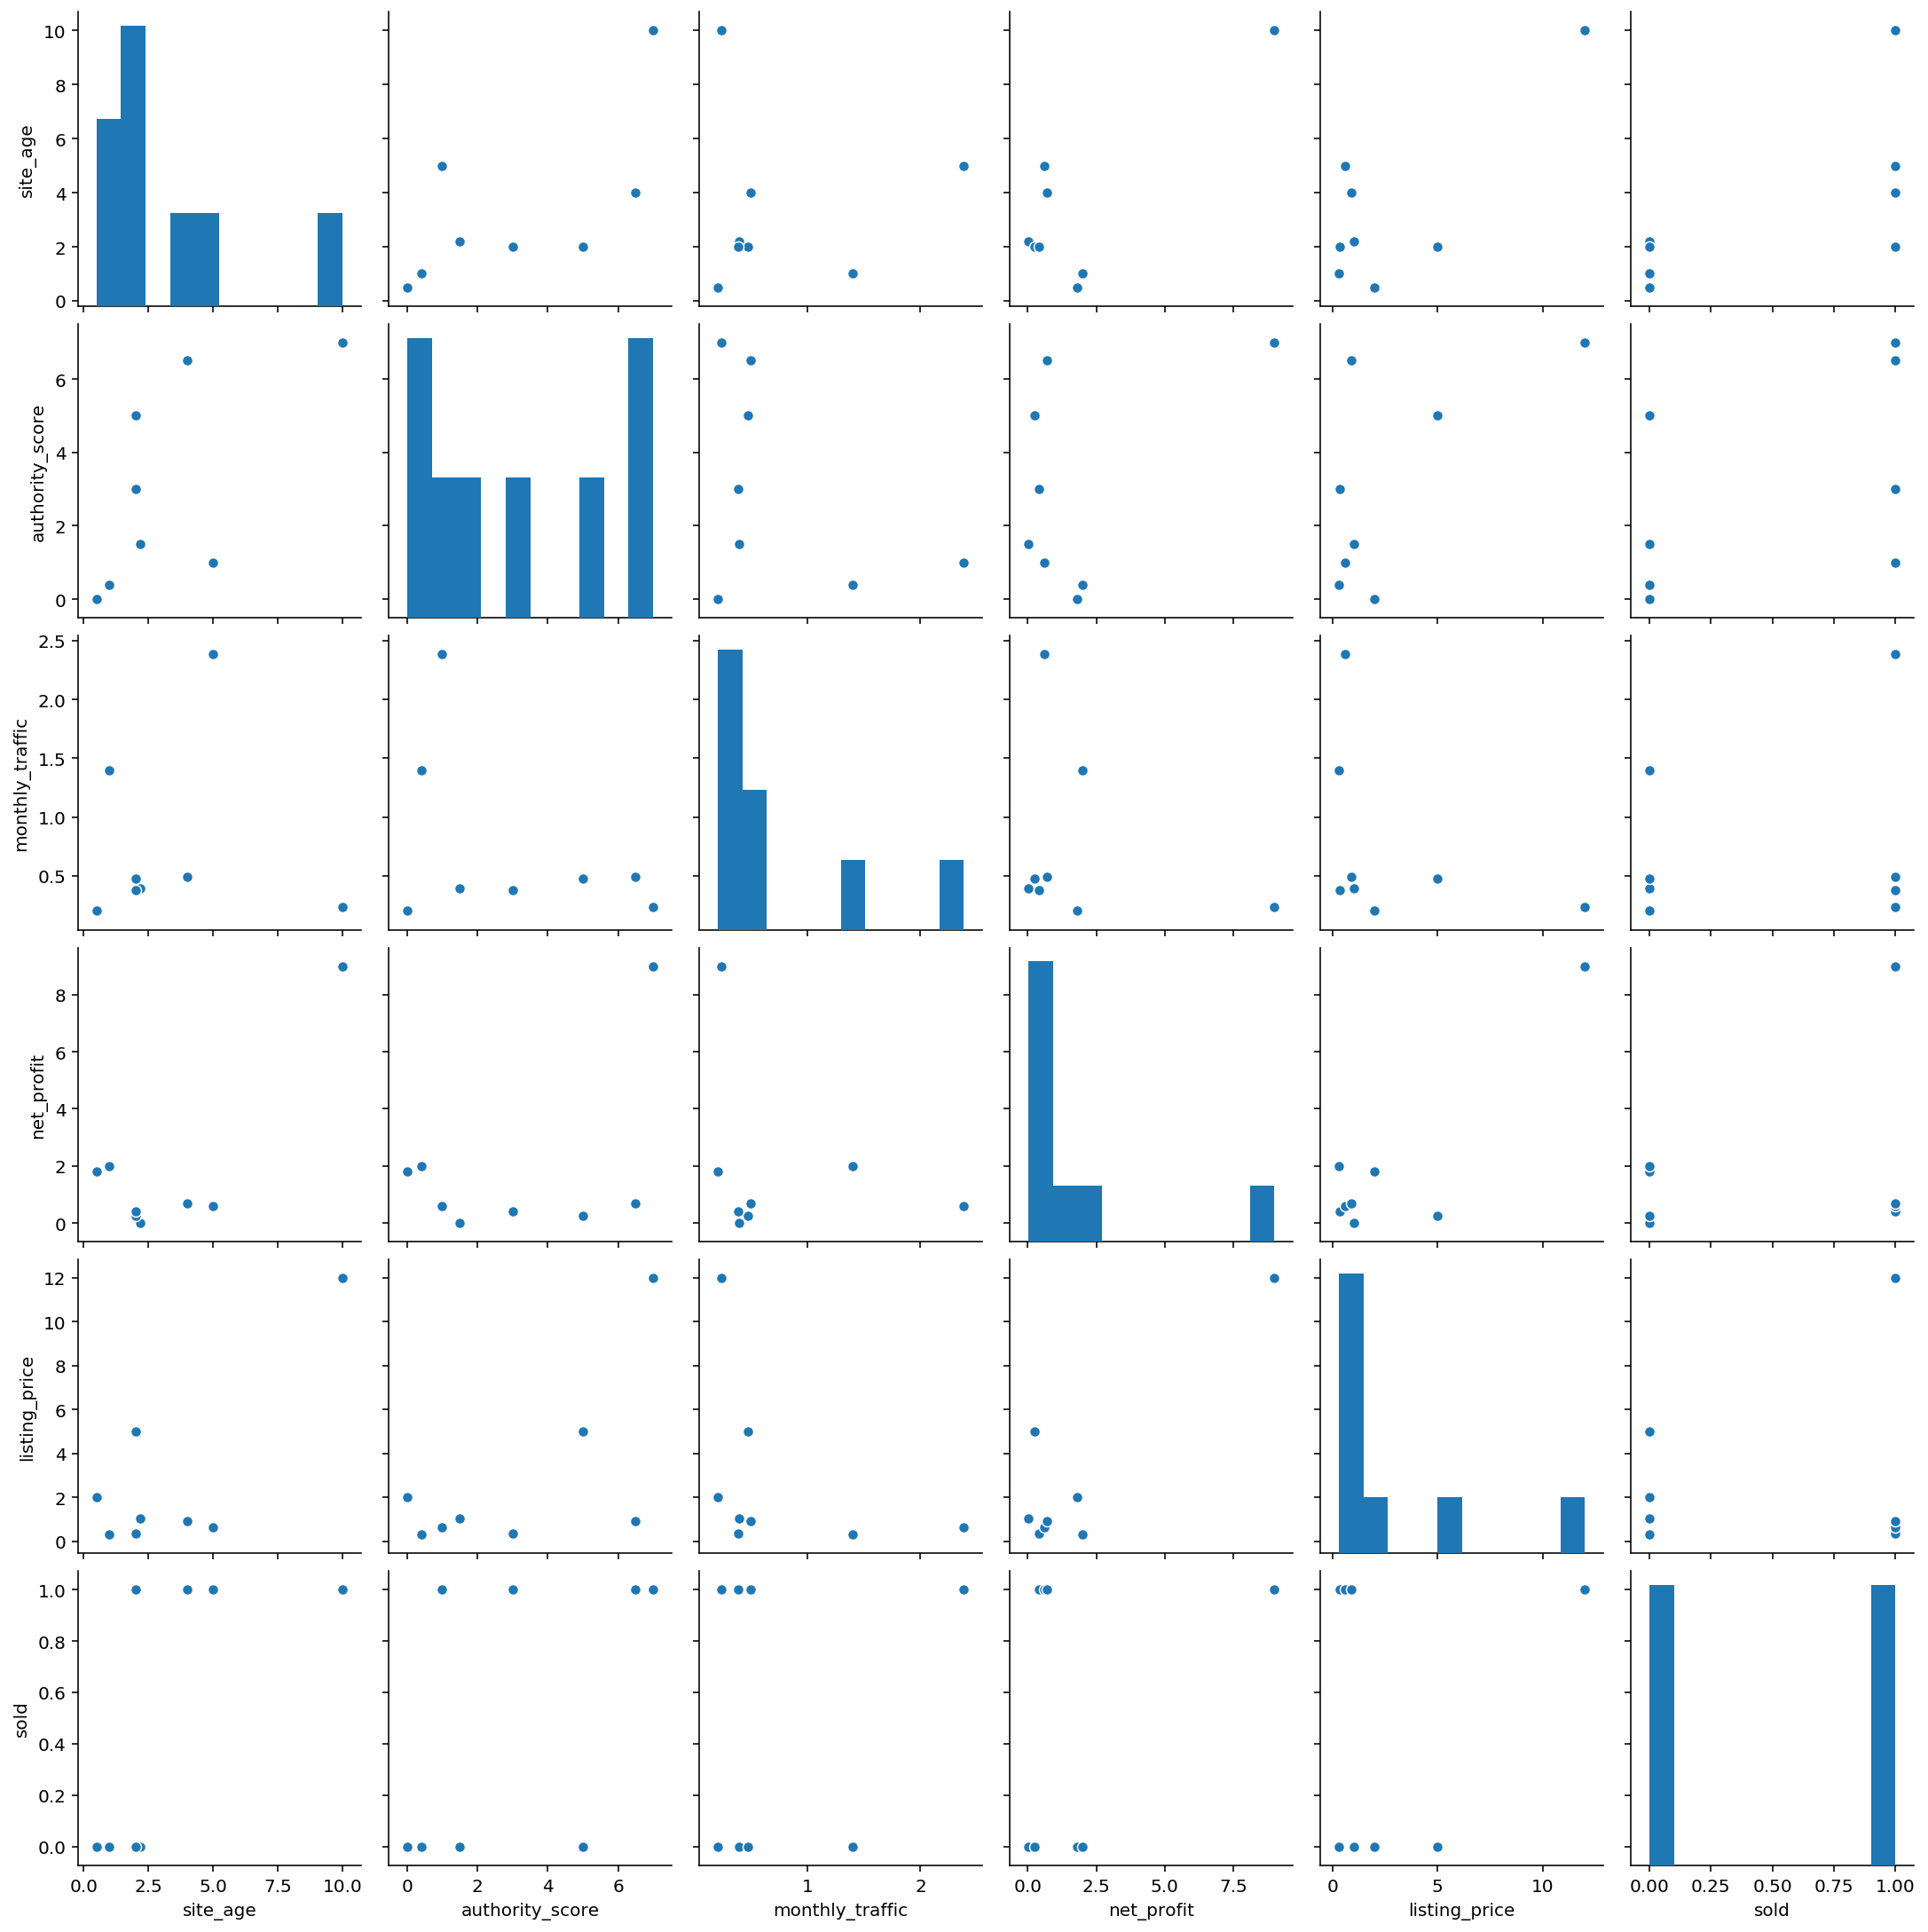

In [4]:
g = sns.pairplot(df)

## Fit Bayesian Model
Let's fit a simple Bayesian Logistic Regression model to this data.

Let’s use the default prior specification for GLM coefficients that PyMC3 gives us, which is p(θ)=N(0,10^12*I). This is a very vague or weakly informative prior that will let the data speak for itsef.

In [5]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "sold ~ site_age + authority_score + monthly_traffic + net_profit + listing_price", df, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag",random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lorre\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [listing_price, net_profit, monthly_traffic, authority_score, site_age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 998 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6114645531540268, but should be close to 0.8. Try to increase the number of tuning steps.
There were 990 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


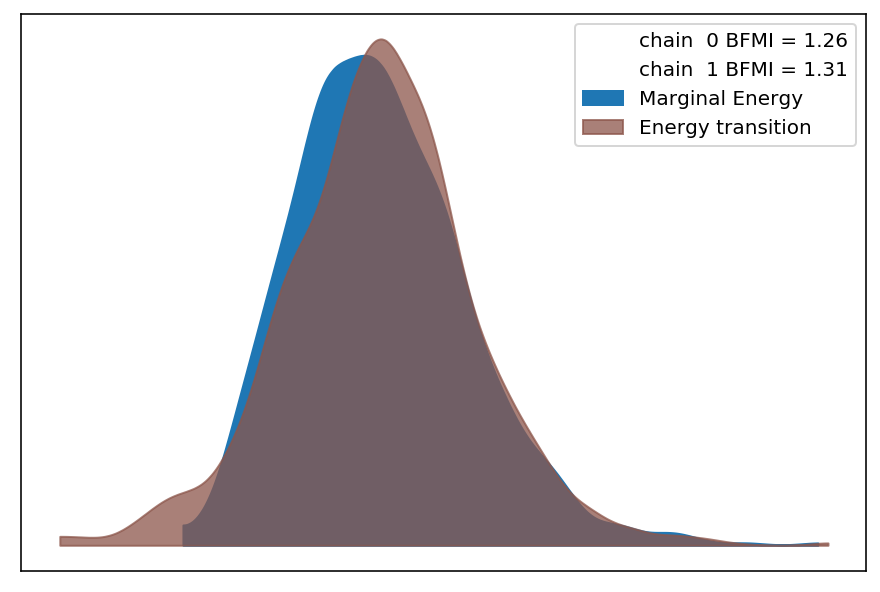

In [6]:
# make sure convergence looks good
az.plot_energy(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B065B01148>,
      dtype=object)

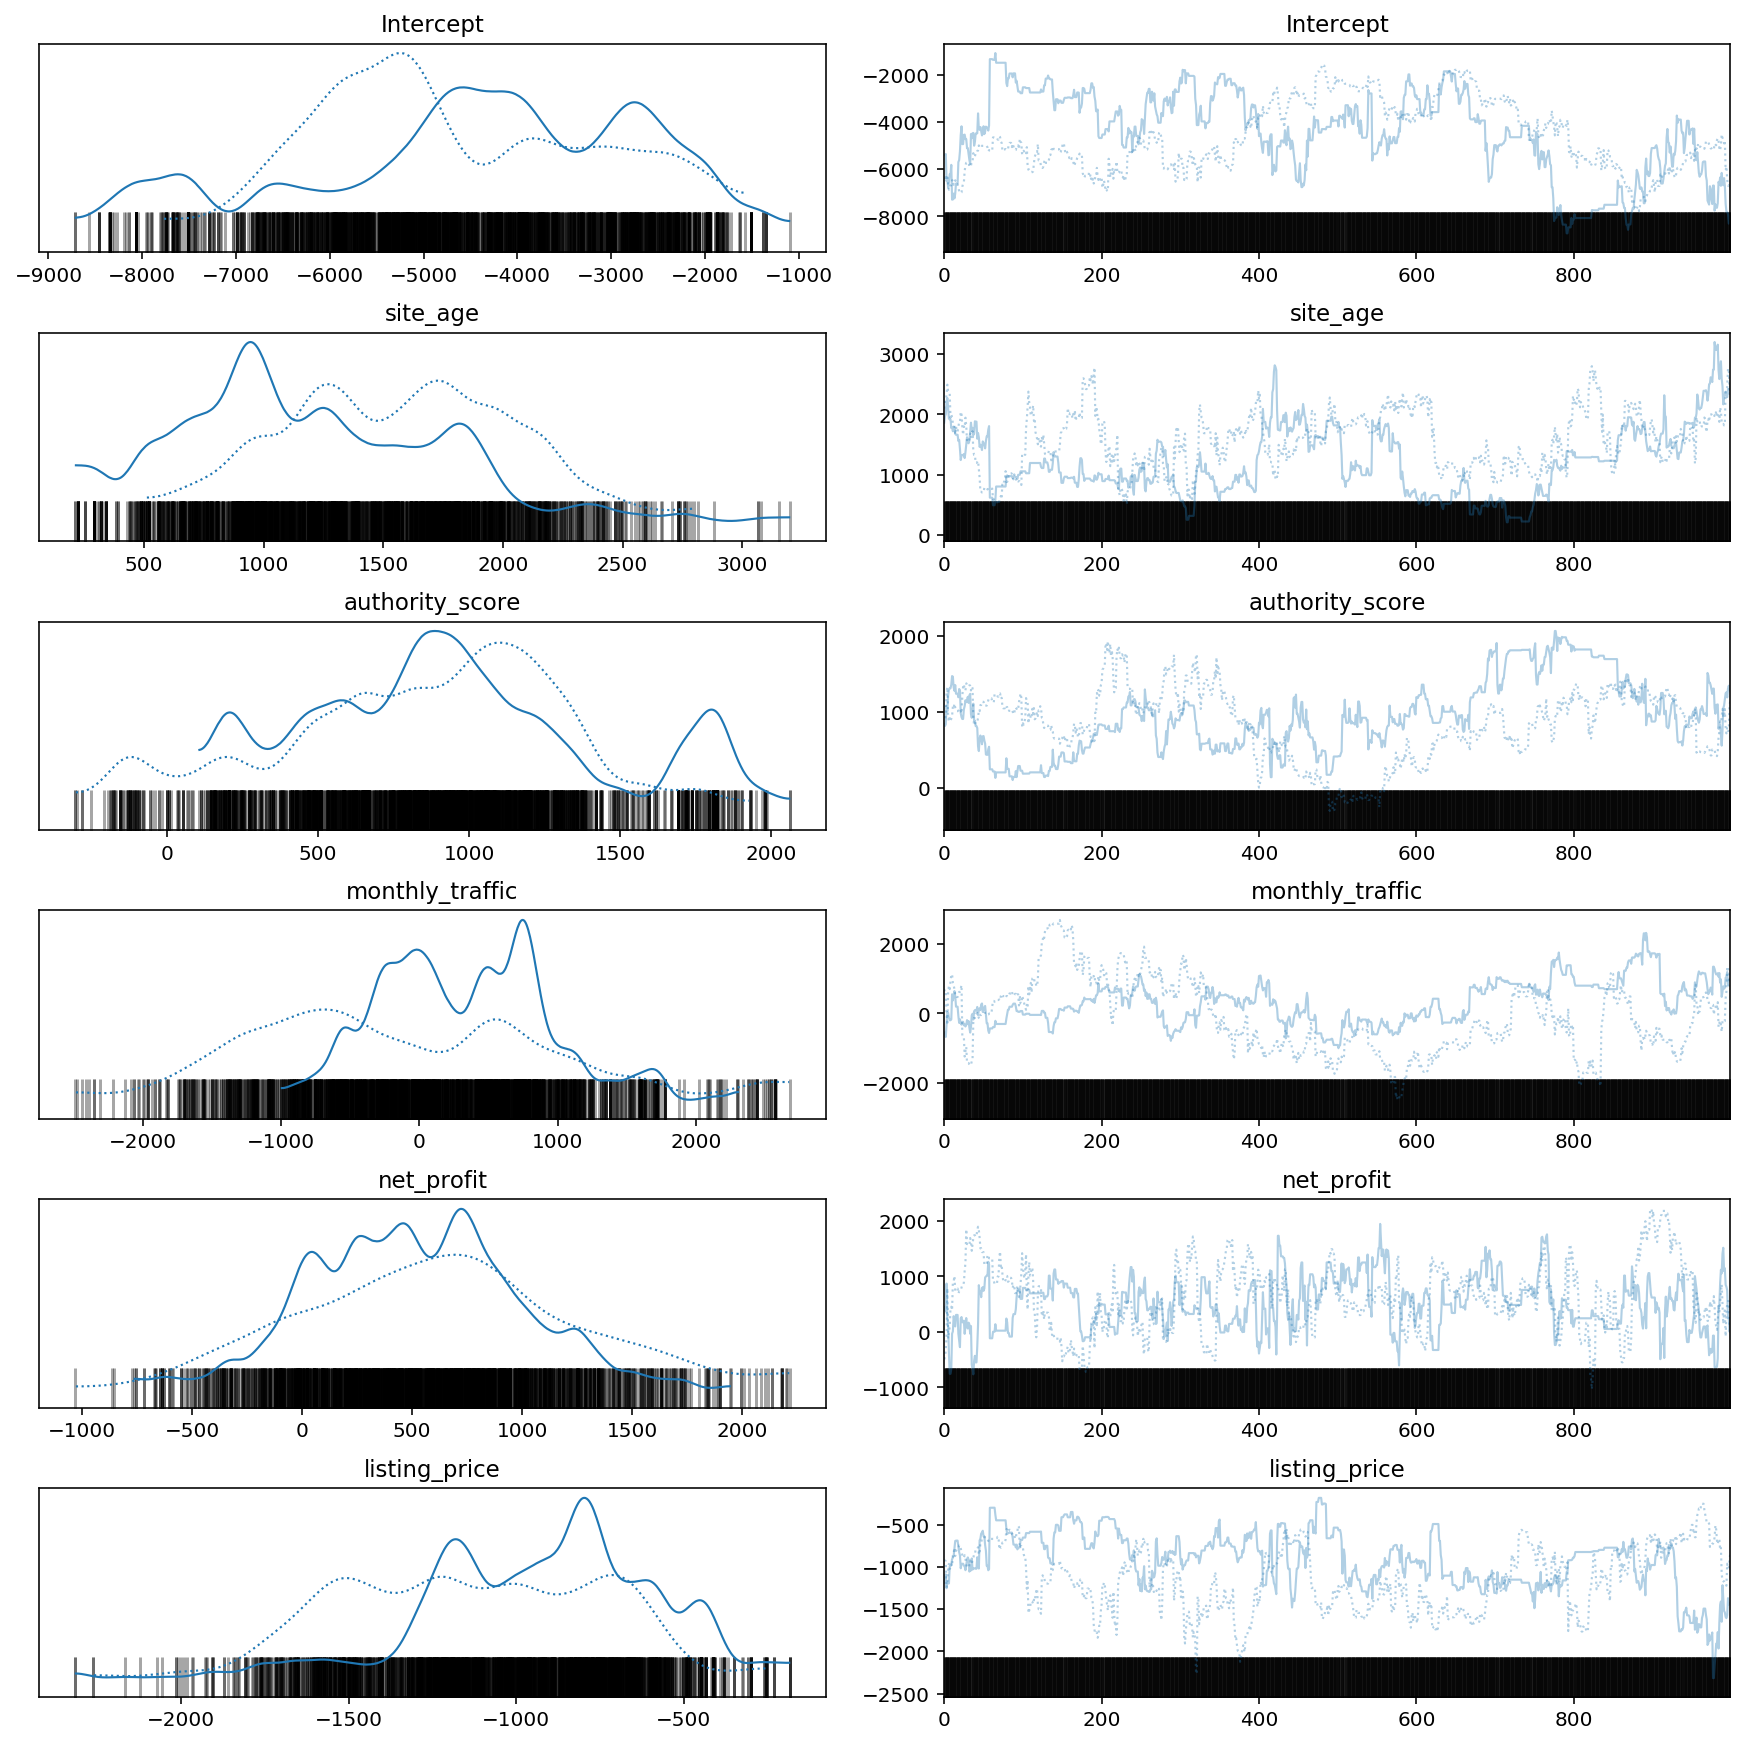

In [7]:
az.plot_trace(trace, compact=True)

In [31]:
logistic_model.model

In [8]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<Figure size 648x504 with 0 Axes>

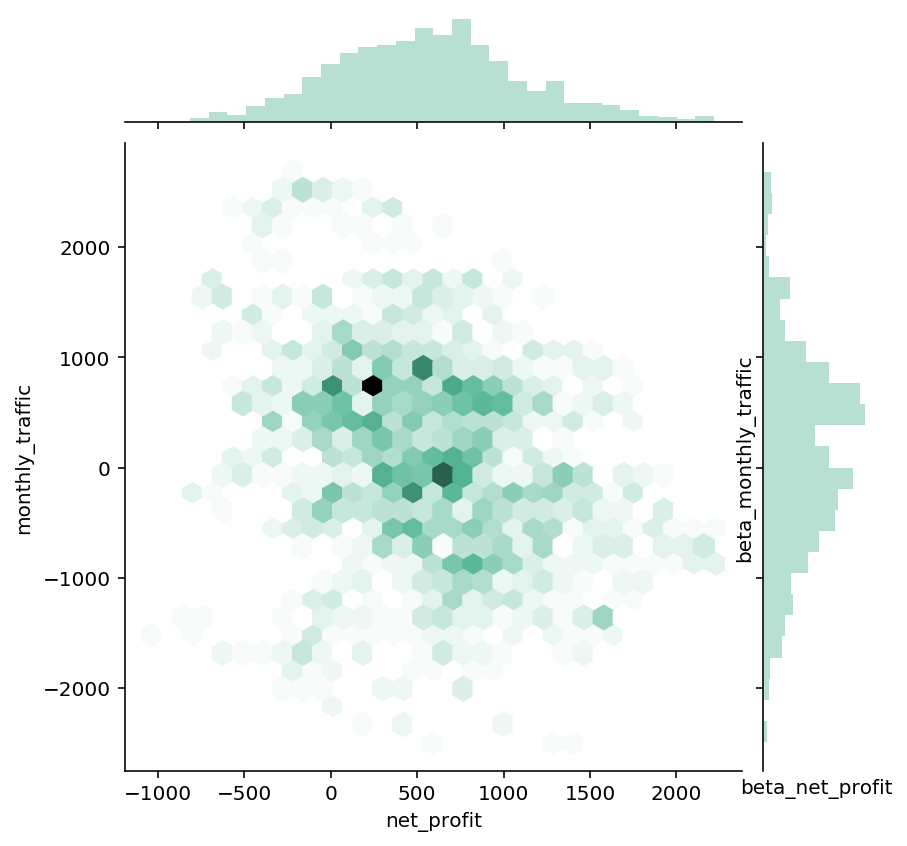

In [9]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace.posterior["net_profit"], trace.posterior["monthly_traffic"], kind="hex", color="#4CB391")
plt.xlabel("beta_net_profit")
plt.ylabel("beta_monthly_traffic");

## Explore the effect of listing price and net profit on the Pr(website sold)

In [27]:
def lm_full(trace, listing_price, net_profit, site_age, authority_score, monthly_traffic):
    shape = np.broadcast( site_age, authority_score, monthly_traffic, net_profit, listing_price).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [site_age, authority_score/10, monthly_traffic/10000, net_profit/1000, listing_price/1000]])
    return 1 / (
        1
        + np.exp(
            -(
                trace["Intercept"]
                + trace["site_age"] * x_norm[0]
                + trace["authority_score"] * x_norm[1]
                + trace["monthly_traffic"] * x_norm[2]
                + trace["net_profit"] * x_norm[3]
                + trace["listing_price"] * x_norm[4]
            )
        )
    )

# Linear model with listing_price=x, net_profit == 100 and site_age=3, authority_score = 40, monthly_traffic=2000
lm1 = lambda x, samples: lm_full(samples, x, 100.0, 3.0,40, 2000)

# Linear model with net_profit == 500 and site_age=3, authority_score = 40, monthly_traffic=2000
lm2 = lambda x, samples: lm_full(samples, x, 500.0, 3.0,40, 2000)

# Linear model with net_profit == 2000 and site_age=3, authority_score = 40, monthly_traffic=2000
lm3 = lambda x, samples: lm_full(samples, x, 2000.0, 3.0,40, 2000)

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning

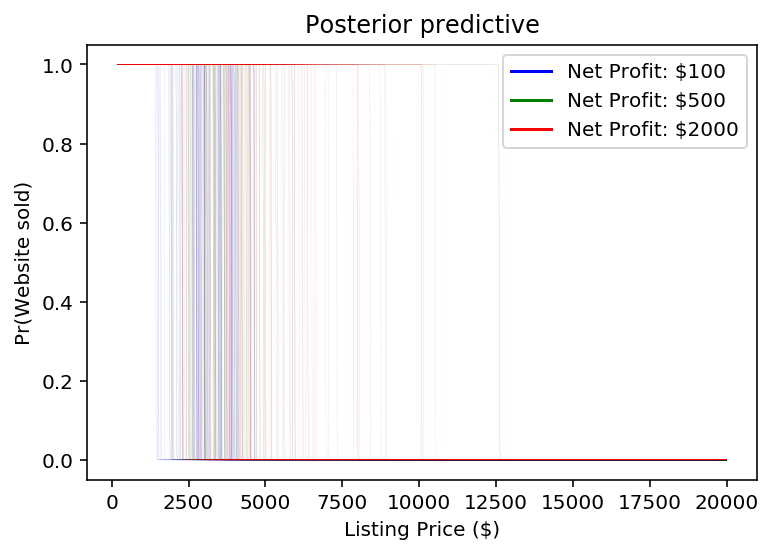

In [29]:
# Plot the posterior predictive distributions of Pr(sold) as function of listing_price (x) 
# and net_profit (groups: 10, 500 ,2000)
price_range = np.linspace(200, 20000, 1000)
pm.plot_posterior_predictive_glm(
    trace, eval=price_range, lm=lm1, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    trace,
    eval=price_range,
    lm=lm2,
    samples=100,
    color="green",
    alpha=0.15,
)
pm.plot_posterior_predictive_glm(
    trace, eval=price_range, lm=lm3, samples=100, color="red", alpha=0.15
)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm1"], [], color="b", label="Net Profit: $100")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Net Profit: $500")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Net Profit: $2000")
plt.legend(handles=[blue_line, green_line, red_line], loc="best")
plt.ylabel("Pr(Website sold)")
plt.xlabel("Listing Price ($)")
plt.show()

Above we note that there are several Runtime warnings due to overflow errors while calculating the Pr(website sold) based on listing price and specified net profit. All net profit bands generally overlapped with each other where too low a listing price gaurenteed the website selling but too high a listing price led to the website not selling on the first try. The transition over listing price is difficult to determine.

## Optimization
Now we have our posterior or the fitted model based on the website listing data provided so we can create a loss function over which to optimize the listing price. In this loss function, we want to maximize the expected return from selling a website. 

Loss function =  Pr(selling website if listed at particular price) * listing_price

Alternatively, we could choose to maximize a more complex function if we were interested in buying websites that don't require too much upkeep relative to its net profit. In this use case, the loss function would need to strike a balance between the cost of running/maintaining these websites and the monthly net profit. 

In [41]:
# get predictive posterior samples
def posterior_predict(price,trace=trace,nsamples = 30):
    # Linear model with listing_price=x, net_profit == 500 and site_age=3, authority_score = 45, monthly_traffic=1000
    lmX = lambda x: lm_full(x, price, 500.0, 3.0, 45, 1000)
    post_pred= []
    for rand_loc in np.random.randint(0, len(trace), nsamples):
        trace1 = trace.posterior.to_dataframe().to_dict(orient="records")
        rand_sample = trace1[rand_loc]
        post_pred.append(lmX(rand_sample))
    return np.array(post_pred)

In [42]:
def loss(price):
    post_pred = posterior_predict(price)
    return -np.mean(post_pred*price)

In [43]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(200, 20000)]
starting_value = [240.0]

In [44]:
from scipy import optimize

#minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: loss(*args), 
                              starting_value, 
                              bounds=bounds)

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


In [45]:
print('Optimal listing price = {}'.format(opt_stoch.x))
print('Optimal expected return = {}'.format(opt_stoch.fun))

Optimal listing price = [3445.02453837]
Optimal expected return = -3445.0245368542974


In [46]:
opt_stoch.message

b'ABNORMAL_TERMINATION_IN_LNSRCH'

In [47]:
opt_stoch.status

2

We try to optimize the Bayesian model based on the data provided but the algorithm  abort abnormally. This likely means that that algorithm cannot find the minimal value of the loss function. So let's plot it to see why..

In [48]:
%%time
vloss = np.vectorize(loss)
post_pred_test1 = vloss(price_range)
post_pred_test1

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


Wall time: 6min 48s


array([-2.00000000e+002, -2.19819820e+002, -2.39639640e+002,
       -2.59459459e+002, -2.79279279e+002, -2.99099099e+002,
       -3.18918919e+002, -3.38738739e+002, -3.58558559e+002,
       -3.78378378e+002, -3.98198198e+002, -4.18018018e+002,
       -4.37837838e+002, -4.57657658e+002, -4.77477477e+002,
       -4.97297297e+002, -5.17117117e+002, -5.36936937e+002,
       -5.56756757e+002, -5.76576577e+002, -5.96396396e+002,
       -6.16216216e+002, -6.36036036e+002, -6.55855856e+002,
       -6.75675676e+002, -6.95495495e+002, -7.15315315e+002,
       -7.35135135e+002, -7.54954955e+002, -7.74774775e+002,
       -7.94594595e+002, -8.14414414e+002, -8.34234234e+002,
       -8.54054054e+002, -8.73873874e+002, -8.93693694e+002,
       -9.13513514e+002, -9.33333333e+002, -9.53153153e+002,
       -9.72972973e+002, -9.92792793e+002, -1.01261261e+003,
       -1.03243243e+003, -1.05225225e+003, -1.07207207e+003,
       -1.09189189e+003, -1.11171171e+003, -1.13153153e+003,
       -1.15135135e+003,

Text(0.5, 1.0, 'Plot of Expected Return as function of Listing Price')

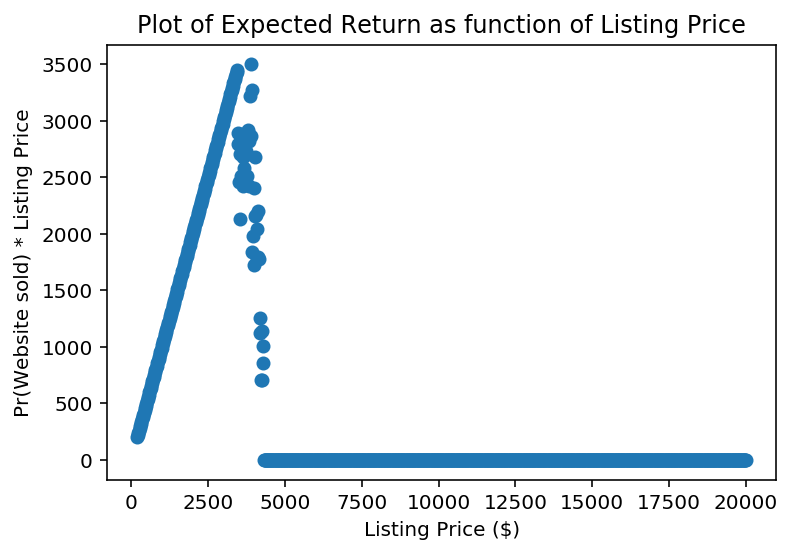

In [49]:
plt.scatter(price_range,-post_pred_test1)
plt.xlabel('Listing Price ($)')
plt.ylabel('Pr(Website sold) * Listing Price')
plt.title('Plot of Expected Return as function of Listing Price')

We see that as listing price increases, the expected return or Pr(website sold)* listing price increases linearly until ~3500 is reached. This suggests that we may need more the data to better explain the Prob(website sold) because Prob decreased before when we held the other features constant (site_age=3, authority_score = 40, monthly_traffic=2000). 

## Learnings
- Scaling features to be on the same order of magnitude significantly helps with convergence.
- Data can affect Bayesian models, especially when weakly informative priors are used for small dataset.
- It is possible to explore relationships between features and response variables.

## Next Steps

An alternative approach may be to include priors instead of using weakly informative priors to "assist" the model with learning the relationships between the features and the response variable. 

What if instead of the listing price, I wanted to determine the closing price for my website, I could use a Bayesian linear regression instead to the closing_price as a function of the other features, then optimize the parameters for my website using the optimized listing_price found.    

### Other steps to take:
- Incorporate categorical variables in the model e.g. website_type ("forum", "blog",  "review", "directory")